# Longformer LED abstractive summarization with metrics

In [1]:
import os
import torch
from transformers import LEDTokenizer, LEDForConditionalGeneration
import evaluate # Hugging Face's evaluate library for metrics
from bert_score import score as bert_score_calc # For BERTScore
import nltk # For sentence tokenization in ROUGE
from nltk.tokenize import sent_tokenize

# Ensure NLTK 'punkt_tab' tokenizer is available for sentence splitting for ROUGE
try:
    nltk.data.find('tokenizers/punkt_tab/english.pickle')
except LookupError:
    print("Downloading 'punkt_tab' NLTK data for ROUGE evaluation...")
    nltk.download('punkt_tab')
    print("'punkt_tab' downloaded.")

# Load the pre-trained LED model and tokenizer for summarization
model_name = "allenai/led-large-16384-arxiv"
tokenizer = LEDTokenizer.from_pretrained(model_name)
model = LEDForConditionalGeneration.from_pretrained(model_name)

# If you have a GPU, move the model to GPU
if torch.cuda.is_available():
    model.to("cuda")
    print("LED model moved to GPU.")
else:
    print("No GPU found, LED model running on CPU.")

def summarize_text(text, max_length=512, min_length=100, num_beams=4, early_stopping=True):
    """
    Summarizes the given text using the LED model.

    Args:
        text (str): The input text to summarize.
        max_length (int): Maximum length of the generated summary.
        min_length (int): Minimum length of the generated summary.
        num_beams (int): Number of beams for beam search.
        early_stopping (bool): Whether to stop beam search when all beams have finished.

    Returns:
        str: The generated summary.
    """
    # Tokenize the input text
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=model.config.max_position_embeddings
    )

    # Move inputs to GPU if model is on GPU
    if torch.cuda.is_available():
        inputs = {k: v.to("cuda") for k, v in inputs.items()}

    # Create global attention mask: global attention on the first token (<s>)
    global_attention_mask = torch.zeros(inputs["input_ids"].shape, dtype=torch.long, device=inputs["input_ids"].device)
    global_attention_mask[:, 0] = 1 # Set global attention on the first token (usually <s>)

    # Generate the summary
    summary_ids = model.generate(
        inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        global_attention_mask=global_attention_mask,
        max_length=max_length,
        min_length=min_length,
        num_beams=num_beams,
        early_stopping=early_stopping,
        no_repeat_ngram_size=3
    )

    # Decode the generated summary
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# --- Example Usage and Evaluation ---
long_text = """
The Amazon rainforest is the largest rainforest in the world, covering an area of approximately 5.5 million square kilometers (2.1 million square miles). It spans across nine South American countries: Brazil, Peru, Colombia, Ecuador, French Guiana, Guyana, Suriname, Venezuela, and Bolivia. The vast majority, around 60%, is located in Brazil.

The Amazon is incredibly biodiverse, home to an estimated 10% of the world's known species, including countless insects, plants, birds, and mammals. Many species in the Amazon are endemic, meaning they are found nowhere else on Earth. This rich biodiversity is sustained by the warm, humid climate and abundant rainfall.

The Amazon River, which flows through the rainforest, is the largest river by discharge volume in the world, and by some measures, also the longest. It is a vital artery for the ecosystem, supporting a vast array of aquatic life.

However, the Amazon rainforest is facing severe threats, primarily from deforestation, driven by cattle ranching, agriculture (soybean farming), logging, and mining. These activities lead to habitat loss, increased carbon emissions, and a reduction in the rainforest's ability to act as a carbon sink, which is crucial for regulating the global climate. Indigenous communities, who have lived in the Amazon for centuries, are also heavily impacted by these threats. Conservation efforts are underway globally to protect this vital ecosystem.
"""

# Define a human-written reference summary for evaluation
# In a real scenario, you would have a ground truth reference summary from your dataset.
reference_summary = """
The Amazon rainforest, the world's largest, spans 5.5 million square kilometers across nine South American countries, with 60% in Brazil. It boasts immense biodiversity, housing 10% of global species, sustained by its humid climate and the Amazon River. However, deforestation from cattle ranching, agriculture, logging, and mining severely threatens it, causing habitat loss, increased carbon emissions, and impacting indigenous communities. Global conservation efforts are crucial to protect this vital ecosystem.
"""

print("Original Text:\n", long_text)

# Generate the summary
generated_summary = summarize_text(long_text)
print("\nGenerated Summary:\n", generated_summary)

# --- Evaluation ---
print("\n--- Evaluating Summary Quality ---")

# 1. ROUGE Metric
# Load ROUGE metric
rouge = evaluate.load("rouge")

# ROUGE expects lists of predictions and references
predictions = [generated_summary]
references = [reference_summary]

# Compute ROUGE scores
# Ensure sentences are split for ROUGE-L to work correctly
# postprocess_text is a common utility for summarization evaluation
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]
    # rougeLSum expects newline separated sentences for sum (abstractive)
    preds = ["\n".join(sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(sent_tokenize(label)) for label in labels]
    return preds, labels

processed_predictions, processed_references = postprocess_text(predictions, references)

rouge_results = rouge.compute(
    predictions=processed_predictions,
    references=processed_references,
    use_stemmer=True, # Use stemming for better matching
    rouge_types=["rouge1", "rouge2", "rougeL", "rougeLsum"] # Common ROUGE types
)

print("\nROUGE Scores:")
for key, value in rouge_results.items():
    print(f"  {key}: {value:.4f}") # Print F-score for ROUGE

# 2. BERTScore Metric
# BERTScore requires a model to compute embeddings; 'bert-base-uncased' is a common choice
# It also needs the generated and reference texts as lists.
print("\nCalculating BERTScore...")
P, R, F1 = bert_score_calc(predictions, references, lang="en", model_type="bert-base-uncased")

print("\nBERTScore:")
print(f"  Precision: {P.mean().item():.4f}")
print(f"  Recall: {R.mean().item():.4f}")
print(f"  F1: {F1.mean().item():.4f}")

print("\nEvaluation complete.")


C:\Users\kalid\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


ModuleNotFoundError: No module named 'bert_score'

# Longformer LED abstractive summarization

In [2]:
from transformers import LEDTokenizer, LEDForConditionalGeneration
import torch

# Load the pre-trained LED model and tokenizer for summarization
# 'allenai/led-large-16384-arxiv' is a good choice for general long document summarization
# There are also specialized models like 'hyesunyun/update-summarization-bart-large-longformer'
# or 'bakhitovd/led-base-7168-ml' for specific domains.
model_name = "allenai/led-large-16384-arxiv"
tokenizer = LEDTokenizer.from_pretrained(model_name)
model = LEDForConditionalGeneration.from_pretrained(model_name)

# If you have a GPU, move the model to GPU
if torch.cuda.is_available():
    model.to("cuda")

def summarize_text(text, max_length=512, min_length=100, num_beams=4, early_stopping=True):
    """
    Summarizes the given text using the LED model.

    Args:
        text (str): The input text to summarize.
        max_length (int): Maximum length of the generated summary.
        min_length (int): Minimum length of the generated summary.
        num_beams (int): Number of beams for beam search.
        early_stopping (bool): Whether to stop beam search when all beams have finished.

    Returns:
        str: The generated summary.
    """
    # Tokenize the input text
    # Longformer models can handle very long inputs (e.g., up to 16384 tokens)
    # global_attention_mask is crucial for Longformer:
    # Set global attention on the first token (<s>) as recommended for summarization.
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=model.config.max_position_embeddings # Use model's max_position_embeddings
    )

    # Move inputs to GPU if model is on GPU
    if torch.cuda.is_available():
        inputs = {k: v.to("cuda") for k, v in inputs.items()}

    # Create global attention mask: global attention on the first token (<s>)
    global_attention_mask = torch.zeros(inputs["input_ids"].shape, dtype=torch.long, device=inputs["input_ids"].device)
    global_attention_mask[:, 0] = 1 # Set global attention on the first token (usually <s>)

    # Generate the summary
    summary_ids = model.generate(
        inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        global_attention_mask=global_attention_mask,
        max_length=max_length,
        min_length=min_length,
        num_beams=num_beams,
        early_stopping=early_stopping,
        no_repeat_ngram_size=3 # To avoid repetitive phrases in the summary
    )

    # Decode the generated summary
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Example Usage:
long_text = """
The Amazon rainforest is the largest rainforest in the world, covering an area of approximately 5.5 million square kilometers (2.1 million square miles). It spans across nine South American countries: Brazil, Peru, Colombia, Ecuador, French Guiana, Guyana, Suriname, Venezuela, and Bolivia. The vast majority, around 60%, is located in Brazil.

The Amazon is incredibly biodiverse, home to an estimated 10% of the world's known species, including countless insects, plants, birds, and mammals. Many species in the Amazon are endemic, meaning they are found nowhere else on Earth. This rich biodiversity is sustained by the warm, humid climate and abundant rainfall.

The Amazon River, which flows through the rainforest, is the largest river by discharge volume in the world, and by some measures, also the longest. It is a vital artery for the ecosystem, supporting a vast array of aquatic life.

However, the Amazon rainforest is facing severe threats, primarily from deforestation, driven by cattle ranching, agriculture (soybean farming), logging, and mining. These activities lead to habitat loss, increased carbon emissions, and a reduction in the rainforest's ability to act as a carbon sink, which is crucial for regulating the global climate. Indigenous communities, who have lived in the Amazon for centuries, are also heavily impacted by these threats. Conservation efforts are underway globally to protect this vital ecosystem.
"""

summary = summarize_text(long_text)
print("Original Text:\n", long_text)
print("\nGenerated Summary:\n", summary)

tokenizer_config.json:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

C:\Users\kalid\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kalid\.cache\huggingface\hub\models--allenai--led-large-16384-arxiv. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/1.84G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/207 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Input ids are automatically padded from 297 to 1024 to be a multiple of `config.attention_window`: 1024


model.safetensors:   0%|          | 0.00/1.84G [00:00<?, ?B/s]

Original Text:
 
The Amazon rainforest is the largest rainforest in the world, covering an area of approximately 5.5 million square kilometers (2.1 million square miles). It spans across nine South American countries: Brazil, Peru, Colombia, Ecuador, French Guiana, Guyana, Suriname, Venezuela, and Bolivia. The vast majority, around 60%, is located in Brazil.

The Amazon is incredibly biodiverse, home to an estimated 10% of the world's known species, including countless insects, plants, birds, and mammals. Many species in the Amazon are endemic, meaning they are found nowhere else on Earth. This rich biodiversity is sustained by the warm, humid climate and abundant rainfall.

The Amazon River, which flows through the rainforest, is the largest river by discharge volume in the world, and by some measures, also the longest. It is a vital artery for the ecosystem, supporting a vast array of aquatic life.

However, the Amazon rainforest is facing severe threats, primarily from deforestation

# Longformer extractive + K means

In [3]:
from transformers import LongformerModel, LongformerTokenizer
import torch
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import re # For sentence splitting

# Load the Longformer model and tokenizer (encoder-only for embeddings)
# We use a base Longformer model here, as we only need the encoder for embeddings.
model_name = "allenai/longformer-base-4096"
extractive_tokenizer = LongformerTokenizer.from_pretrained(model_name)
extractive_model = LongformerModel.from_pretrained(model_name)

# If you have a GPU, move the model to GPU
if torch.cuda.is_available():
    extractive_model.to("cuda")

def split_sentences(text):
    """
    Splits text into sentences. A basic regex for demonstration.
    For more robust splitting, consider NLTK's sent_tokenize.
    """
    # Using regex to split by common sentence-ending punctuation
    # followed by whitespace or end of string.
    sentences = re.split(r'(?<=[.!?])\s+', text.strip())
    # Filter out empty strings that might result from splitting
    sentences = [s.strip() for s in sentences if s.strip()]
    return sentences

def get_sentence_embeddings(sentences):
    """
    Generates embeddings for a list of sentences using Longformer.
    We take the [CLS] token's embedding as the sentence representation.
    """
    embeddings = []
    for sentence in sentences:
        # Tokenize each sentence. Add global attention to the [CLS] token.
        # This is important for Longformer to properly form a summary representation.
        inputs = extractive_tokenizer(
            sentence,
            return_tensors="pt",
            truncation=True,
            max_length=extractive_model.config.max_position_embeddings
        )

        # Move inputs to GPU if model is on GPU
        if torch.cuda.is_available():
            inputs = {k: v.to("cuda") for k, v in inputs.items()}

        # Create global attention mask: global attention on the first token (<s> or [CLS])
        # For LongformerEncoder only, [CLS] is at index 0.
        global_attention_mask = torch.zeros(inputs["input_ids"].shape, dtype=torch.long, device=inputs["input_ids"].device)
        global_attention_mask[:, 0] = 1

        with torch.no_grad():
            # Get the last hidden states
            outputs = extractive_model(
                inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                global_attention_mask=global_attention_mask
            )
            # Take the embedding of the [CLS] token (first token)
            sentence_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
            embeddings.append(sentence_embedding)
    return np.array(embeddings)

def extractive_summarize_longformer_kmeans(text, num_sentences=3):
    """
    Performs extractive summarization using Longformer embeddings and K-Means.

    Args:
        text (str): The input text to summarize.
        num_sentences (int): The desired number of sentences in the summary.

    Returns:
        str: The extractive summary.
    """
    sentences = split_sentences(text)
    if not sentences:
        return ""
    if num_sentences >= len(sentences):
        return " ".join(sentences)

    sentence_embeddings = get_sentence_embeddings(sentences)

    # Perform K-Means clustering
    n_clusters = min(num_sentences, len(sentences)) # Number of clusters can't exceed number of sentences
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
    kmeans.fit(sentence_embeddings)

    # Find the sentence closest to each cluster centroid
    # This selects representative sentences for each cluster
    closest_sentences_indices = []
    for i in range(n_clusters):
        centroid = kmeans.cluster_centers_[i]
        # Calculate cosine similarity between centroid and all sentences
        distances = cosine_similarity([centroid], sentence_embeddings)[0]
        # Get the index of the sentence closest to the centroid
        closest_sentence_idx = np.argmax(distances)
        closest_sentences_indices.append(closest_sentence_idx)

    # Get unique indices and sort them to maintain original sentence order
    unique_indices = sorted(list(set(closest_sentences_indices)))
    
    # Ensure we get at most num_sentences
    selected_indices = unique_indices[:num_sentences]
    
    summary_sentences = [sentences[idx] for idx in selected_indices]
    return " ".join(summary_sentences)


# --- Example Usage ---
long_document = """
The Amazon rainforest is the largest rainforest in the world, covering an area of approximately 5.5 million square kilometers (2.1 million square miles). It spans across nine South American countries: Brazil, Peru, Colombia, Ecuador, French Guiana, Guyana, Suriname, Venezuela, and Bolivia. The vast majority, around 60%, is located in Brazil.

The Amazon is incredibly biodiverse, home to an estimated 10% of the world's known species, including countless insects, plants, birds, and mammals. Many species in the Amazon are endemic, meaning they are found nowhere else on Earth. This rich biodiversity is sustained by the warm, humid climate and abundant rainfall.

The Amazon River, which flows through the rainforest, is the largest river by discharge volume in the world, and by some measures, also the longest. It is a vital artery for the ecosystem, supporting a vast array of aquatic life.

However, the Amazon rainforest is facing severe threats, primarily from deforestation, driven by cattle ranching, agriculture (soybean farming), logging, and mining. These activities lead to habitat loss, increased carbon emissions, and a reduction in the rainforest's ability to act as a carbon sink, which is crucial for regulating the global climate. Indigenous communities, who have lived in the Amazon for centuries, are also heavily impacted by these threats. Conservation efforts are underway globally to protect this vital ecosystem.
"""

print("Original Document:\n", long_document)
print("\n" + "="*50 + "\n")

extractive_summary = extractive_summarize_longformer_kmeans(long_document, num_sentences=3)
print("Extractive Summary (Longformer + K-Means):\n", extractive_summary)

tokenizer.json: 0.00B [00:00, ?B/s]

C:\Users\kalid\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kalid\.cache\huggingface\hub\models--allenai--longformer-base-4096. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Input ids are automatically padded to be a multiple of `config.attention_window`: 512


Original Document:
 
The Amazon rainforest is the largest rainforest in the world, covering an area of approximately 5.5 million square kilometers (2.1 million square miles). It spans across nine South American countries: Brazil, Peru, Colombia, Ecuador, French Guiana, Guyana, Suriname, Venezuela, and Bolivia. The vast majority, around 60%, is located in Brazil.

The Amazon is incredibly biodiverse, home to an estimated 10% of the world's known species, including countless insects, plants, birds, and mammals. Many species in the Amazon are endemic, meaning they are found nowhere else on Earth. This rich biodiversity is sustained by the warm, humid climate and abundant rainfall.

The Amazon River, which flows through the rainforest, is the largest river by discharge volume in the world, and by some measures, also the longest. It is a vital artery for the ecosystem, supporting a vast array of aquatic life.

However, the Amazon rainforest is facing severe threats, primarily from deforesta

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/597M [00:00<?, ?B/s]

C:\Users\kalid\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Extractive Summary (Longformer + K-Means):
 It spans across nine South American countries: Brazil, Peru, Colombia, Ecuador, French Guiana, Guyana, Suriname, Venezuela, and Bolivia. This rich biodiversity is sustained by the warm, humid climate and abundant rainfall. The Amazon River, which flows through the rainforest, is the largest river by discharge volume in the world, and by some measures, also the longest.


# Lonformer extractive + centroid

In [5]:
# Re-use Longformer model and tokenizer from Method 1
# extractive_tokenizer = LongformerTokenizer.from_pretrained(model_name)
# extractive_model = LongformerModel.from_pretrained(model_name)
# (Ensure they are loaded if you're running this independently)

def extractive_summarize_longformer_centroid(text, num_sentences=3):
    """
    Performs extractive summarization using Longformer embeddings and centroid similarity.

    Args:
        text (str): The input text to summarize.
        num_sentences (int): The desired number of sentences in the summary.

    Returns:
        str: The extractive summary.
    """
    sentences = split_sentences(text)
    if not sentences:
        return ""
    if num_sentences >= len(sentences):
        return " ".join(sentences)

    sentence_embeddings = get_sentence_embeddings(sentences)

    # Calculate the document centroid (average of all sentence embeddings)
    document_centroid = np.mean(sentence_embeddings, axis=0)

    # Calculate cosine similarity between each sentence and the document centroid
    similarities = cosine_similarity([document_centroid], sentence_embeddings)[0]

    # Get the indices of the top 'num_sentences' most similar sentences
    # Use argsort to get indices that would sort the array, then reverse and slice
    top_sentence_indices = np.argsort(similarities)[::-1][:num_sentences]

    # Sort the selected indices to preserve the original order of sentences in the summary
    sorted_top_indices = sorted(top_sentence_indices)

    summary_sentences = [sentences[idx] for idx in sorted_top_indices]
    return " ".join(summary_sentences)

# --- Example Usage for Centroid Method ---
print("\n" + "="*50 + "\n")
extractive_summary_centroid = extractive_summarize_longformer_centroid(long_document, num_sentences=5)
print("Extractive Summary (Longformer + Centroid Similarity):\n", extractive_summary_centroid)



Extractive Summary (Longformer + Centroid Similarity):
 The Amazon is incredibly biodiverse, home to an estimated 10% of the world's known species, including countless insects, plants, birds, and mammals. Many species in the Amazon are endemic, meaning they are found nowhere else on Earth. This rich biodiversity is sustained by the warm, humid climate and abundant rainfall. It is a vital artery for the ecosystem, supporting a vast array of aquatic life. Indigenous communities, who have lived in the Amazon for centuries, are also heavily impacted by these threats.


In [4]:
import os
import torch
from transformers import LongformerTokenizer, LongformerModel
import evaluate # Hugging Face's evaluate library for metrics
from bert_score import score as bert_score_calc # For BERTScore
import nltk # For sentence tokenization
from nltk.tokenize import sent_tokenize
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Ensure NLTK 'punkt_tab' tokenizer is available for sentence splitting
try:
    nltk.data.find('tokenizers/punkt_tab/english.pickle')
except LookupError:
    print("Downloading 'punkt_tab' NLTK data for sentence splitting...")
    nltk.download('punkt_tab')
    print("'punkt_tab' downloaded.")

# --- 0. Load Longformer Model and Tokenizer for Embeddings ---
# We use LongformerModel (the base encoder) to get sentence embeddings.
# If you fine-tuned LongformerForSequenceClassification, you can load that,
# but for just embeddings, the base model is sufficient.
MODEL_NAME_FOR_EMBEDDINGS = "allenai/longformer-base-4096" # Or the path to your fine-tuned model if it's LongformerForSequenceClassification

print(f"Loading Longformer model and tokenizer for embeddings from: {MODEL_NAME_FOR_EMBEDDINGS}")
extractive_tokenizer = LongformerTokenizer.from_pretrained(MODEL_NAME_FOR_EMBEDDINGS)
extractive_model = LongformerModel.from_pretrained(MODEL_NAME_FOR_EMBEDDINGS) # Use LongformerModel for embeddings

# If you have a GPU, move the model to GPU
if torch.cuda.is_available():
    extractive_model.to("cuda")
    print("Longformer model for embeddings moved to GPU.")
else:
    print("No GPU found, Longformer model for embeddings running on CPU.")

# Set model to evaluation mode
extractive_model.eval()

# --- Helper Functions for Extractive Summarization ---

def split_sentences(text):
    """Splits text into sentences using NLTK."""
    return sent_tokenize(text)

def get_sentence_embeddings(sentences):
    """
    Generates embeddings for a list of sentences using the Longformer model.
    We use the [CLS] token embedding as the sentence representation.
    """
    if not sentences:
        return np.array([])

    # Process sentences in batches to avoid OOM for very long documents
    batch_size = 8 # Adjust based on your GPU memory
    embeddings = []

    for i in range(0, len(sentences), batch_size):
        batch_sentences = sentences[i:i + batch_size]
        inputs = extractive_tokenizer(
            batch_sentences,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512 # Max length for individual sentences
        )

        if torch.cuda.is_available():
            inputs = {k: v.to("cuda") for k, v in inputs.items()}

        with torch.no_grad():
            outputs = extractive_model(**inputs)

        # Get the embeddings of the [CLS] token (first token) for each sentence
        # outputs.last_hidden_state has shape (batch_size, sequence_length, hidden_size)
        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(cls_embeddings)

    return np.vstack(embeddings)


def extractive_summarize_longformer_centroid(text, num_sentences=3):
    """
    Performs extractive summarization using Longformer embeddings and centroid similarity.

    Args:
        text (str): The input text to summarize.
        num_sentences (int): The desired number of sentences in the summary.

    Returns:
        str: The extractive summary.
    """
    sentences = split_sentences(text)
    if not sentences:
        return ""
    if num_sentences >= len(sentences):
        return " ".join(sentences)

    sentence_embeddings = get_sentence_embeddings(sentences)

    # Calculate the document centroid (average of all sentence embeddings)
    document_centroid = np.mean(sentence_embeddings, axis=0)

    # Calculate cosine similarity between each sentence and the document centroid
    similarities = cosine_similarity([document_centroid], sentence_embeddings)[0]

    # Get the indices of the top 'num_sentences' most similar sentences
    # Use argsort to get indices that would sort the array, then reverse and slice
    top_sentence_indices = np.argsort(similarities)[::-1][:num_sentences]

    # Sort the selected indices to preserve the original order of sentences in the summary
    sorted_top_indices = sorted(top_sentence_indices)

    summary_sentences = [sentences[idx] for idx in sorted_top_indices]
    return " ".join(summary_sentences)

# --- Example Usage and Evaluation for Centroid Method ---
long_document = """
The Amazon rainforest is the largest rainforest in the world, covering an area of approximately 5.5 million square kilometers (2.1 million square miles). It spans across nine South American countries: Brazil, Peru, Colombia, Ecuador, French Guiana, Guyana, Suriname, Venezuela, and Bolivia. The vast majority, around 60%, is located in Brazil.

The Amazon is incredibly biodiverse, home to an estimated 10% of the world's known species, including countless insects, plants, birds, and mammals. Many species in the Amazon are endemic, meaning they are found nowhere else on Earth. This rich biodiversity is sustained by the warm, humid climate and abundant rainfall.

The Amazon River, which flows through the rainforest, is the largest river by discharge volume in the world, and by some measures, also the longest. It is a vital artery for the ecosystem, supporting a vast array of aquatic life.

However, the Amazon rainforest is facing severe threats, primarily from deforestation, driven by cattle ranching, agriculture (soybean farming), logging, and mining. These activities lead to habitat loss, increased carbon emissions, and a reduction in the rainforest's ability to act as a carbon sink, which is crucial for regulating the global climate. Indigenous communities, who have lived in the Amazon for centuries, are also heavily impacted by these threats. Conservation efforts are underway globally to protect this vital ecosystem.
"""

# Define a human-written reference summary for evaluation
reference_summary_extractive = """
The Amazon rainforest is the largest rainforest in the world, covering an area of approximately 5.5 million square kilometers (2.1 million square miles). It spans across nine South American countries: Brazil, Peru, Colombia, Ecuador, French Guiana, Guyana, Suriname, Venezuela, and Bolivia. The vast majority, around 60%, is located in Brazil. The Amazon is incredibly biodiverse, home to an estimated 10% of the world's known species, including countless insects, plants, birds, and mammals. Conservation efforts are underway globally to protect this vital ecosystem.
"""

print("\n" + "="*50 + "\n")
print("Original Document:\n", long_document)

num_sentences_in_summary = 5
extractive_summary_centroid = extractive_summarize_longformer_centroid(long_document, num_sentences=num_sentences_in_summary)
print(f"\nExtractive Summary (Longformer + Centroid Similarity - Top {num_sentences_in_summary} sentences):\n", extractive_summary_centroid)

# --- Evaluation for Extractive Summary ---
print("\n--- Evaluating Extractive Summary Quality ---")

# 1. ROUGE Metric
rouge = evaluate.load("rouge")

predictions_extractive = [extractive_summary_centroid]
references_extractive = [reference_summary_extractive]

# Ensure sentences are split for ROUGE-L to work correctly
def postprocess_text_for_rouge(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]
    # For ROUGE, especially Lsum, it's good to have sentences separated by newlines
    preds = ["\n".join(sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(sent_tokenize(label)) for label in labels]
    return preds, labels

processed_predictions_extractive, processed_references_extractive = postprocess_text_for_rouge(predictions_extractive, references_extractive)

rouge_results_extractive = rouge.compute(
    predictions=processed_predictions_extractive,
    references=processed_references_extractive,
    use_stemmer=True,
    rouge_types=["rouge1", "rouge2", "rougeL", "rougeLsum"]
)

print("\nROUGE Scores (Extractive Summary):")
for key, value in rouge_results_extractive.items():
    print(f"  {key}: {value:.4f}")

# 2. BERTScore Metric
print("\nCalculating BERTScore (Extractive Summary)...")
P_extractive, R_extractive, F1_extractive = bert_score_calc(
    predictions_extractive,
    references_extractive,
    lang="en",
    model_type="bert-base-uncased"
)

print("\nBERTScore (Extractive Summary):")
print(f"  Precision: {P_extractive.mean().item():.4f}")
print(f"  Recall: {R_extractive.mean().item():.4f}")
print(f"  F1: {F1_extractive.mean().item():.4f}")

print("\nExtractive summarization and evaluation complete.")


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\kalid\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


'punkt_tab' downloaded.
Loading Longformer model and tokenizer for embeddings from: allenai/longformer-base-4096


Input ids are automatically padded to be a multiple of `config.attention_window`: 512


No GPU found, Longformer model for embeddings running on CPU.


Original Document:
 
The Amazon rainforest is the largest rainforest in the world, covering an area of approximately 5.5 million square kilometers (2.1 million square miles). It spans across nine South American countries: Brazil, Peru, Colombia, Ecuador, French Guiana, Guyana, Suriname, Venezuela, and Bolivia. The vast majority, around 60%, is located in Brazil.

The Amazon is incredibly biodiverse, home to an estimated 10% of the world's known species, including countless insects, plants, birds, and mammals. Many species in the Amazon are endemic, meaning they are found nowhere else on Earth. This rich biodiversity is sustained by the warm, humid climate and abundant rainfall.

The Amazon River, which flows through the rainforest, is the largest river by discharge volume in the world, and by some measures, also the longest. It is a vital artery for the ecosystem, supporting a vast array of aquatic life.

However, the Amaz

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\kalid\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kalid\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


BERTScore (Extractive Summary):
  Precision: 0.6919
  Recall: 0.6583
  F1: 0.6747

Extractive summarization and evaluation complete.


In [3]:
!pip install bert_score

  Obtaining dependency information for bert_score from https://files.pythonhosted.org/packages/c6/8c/bc5457de4c004b1a623b31f7bc8d0375fb699b7d67df11879098b4b7b7c8/bert_score-0.3.13-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/61.1 kB ? eta -:--:--
   -------------------- ------------------- 30.7/61.1 kB ? eta -:--:--
   -------------------- ------------------- 30.7/61.1 kB ? eta -:--:--
   -------------------- ------------------- 30.7/61.1 kB ? eta -:--:--
   -------------------------- ------------- 41.0/61.1 kB 164.3 kB/s eta 0:00:01
   ---------------------------------------- 61.1/61.1 kB 233.5 kB/s eta 0:00:00


# labeling dataset using rogue

In [ ]:
from datasets import load_dataset
import evaluate # For ROUGE
import nltk
from nltk.tokenize import sent_tokenize
import numpy as np

# Download 'punkt' tokenizer for NLTK if you haven't
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt')

# Load a dataset, e.g., CNN/DailyMail
# For fine-tuning, you'll typically use the 'train' split
dataset = load_dataset("cnn_dailymail", "3.0.0", split="train")

# Load ROUGE metric
rouge = evaluate.load("rouge")

def create_extractive_labels(example, rouge_threshold=0.2):
    document = example["article"]
    abstractive_summary = example["highlights"]

    sentences = sent_tokenize(document, language='english')
    
    # Initialize labels: 0 for not in summary, 1 for in summary
    extractive_labels = [0] * len(sentences)
    
    # Store ROUGE scores for each sentence
    sentence_rouge_scores = []

    for i, sentence in enumerate(sentences):
        # Calculate ROUGE-L between the sentence and the abstractive summary
        # We use 'score_only' to get the F1 score directly
        score = rouge.compute(
            predictions=[sentence],
            references=[abstractive_summary],
            rouge_types=["rougeL"],
            use_stemmer=True, # Often used for ROUGE computation
            # You might need to disable parallelization for small inputs if you hit issues
            # e.g., 'use_aggregator=False' and manually aggregate if needed
        )['rougeL']
        sentence_rouge_scores.append(score)
        
        if score >= rouge_threshold:
            extractive_labels[i] = 1
            
    example["sentences"] = sentences
    example["extractive_labels"] = extractive_labels
    example["sentence_rouge_scores"] = sentence_rouge_scores
    return example

# Apply the labeling function to your dataset
# This might take some time for large datasets
# For demonstration, let's take a small subset
# processed_dataset = dataset.select(range(100)).map(create_extractive_labels)
# print(processed_dataset[0])

# --- Alternative for fixed N sentences (e.g., top 3 sentences) ---
def create_fixed_n_extractive_labels(example, num_sentences_to_extract=3):
    document = example["article"]
    abstractive_summary = example["highlights"]

    sentences = sent_tokenize(document, language='english')
    if not sentences:
        return {"sentences": [], "extractive_labels": [], "sentence_rouge_scores": []}

    extractive_labels = [0] * len(sentences)
    
    sentence_rouge_f1s = []
    for i, sentence in enumerate(sentences):
        # Calculate ROUGE-L F1 score for each sentence
        score = rouge.compute(
            predictions=[sentence],
            references=[abstractive_summary],
            rouge_types=["rougeL"],
            use_stemmer=True,
        )['rougeL']
        sentence_rouge_f1s.append((score, i)) # Store (score, original_index)

    # Sort sentences by ROUGE score in descending order
    sentence_rouge_f1s.sort(key=lambda x: x[0], reverse=True)

    # Select the top N sentences and mark them
    selected_indices = []
    for score, original_idx in sentence_rouge_f1s[:num_sentences_to_extract]:
        extractive_labels[original_idx] = 1
        selected_indices.append(original_idx)
    
    # Sort selected indices to preserve original order for the actual summary
    selected_indices.sort()
    
    example["sentences"] = sentences
    example["extractive_labels"] = extractive_labels
    example["selected_extractive_sentences"] = [sentences[idx] for idx in selected_indices]
    return example

# Example of applying the fixed-N labeling
processed_dataset_fixed_n = dataset.select(range(5)).map(create_fixed_n_extractive_labels)
print(processed_dataset_fixed_n[0])       


# did not run this block

# Labeling dataset and storing the dataset

In [15]:
import os
import evaluate
import nltk
from nltk.tokenize import sent_tokenize
from datasets import load_dataset, load_from_disk
import numpy as np
from nltk.tokenize import sent_tokenize

# --- 0. Setup and Pre-requisites ---
# Ensure NLTK 'punkt' tokenizer is available for sentence splitting
import nltk
import os

# Force-download punkt to a local directory to avoid LookupError
nltk.download('punkt', download_dir='./nltk_data')
nltk.data.path.append('./nltk_data')  # Tell nltk where to look

try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt')

# Load the ROUGE metric from the 'evaluate' library
# This is used to compare sentences to the abstractive summary for labeling
rouge = evaluate.load("rouge")

# Define the output directory for your labeled dataset
# This will be created if it doesn't exist.
OUTPUT_DATA_DIR = "./labeled_summarization_dataset"
os.makedirs(OUTPUT_DATA_DIR, exist_ok=True)

# --- 1. Define the Data Labeling Function ---
# This function takes a single example from the dataset and adds extractive labels
def create_fixed_n_extractive_labels(example, num_sentences_to_extract=3):
    """
    Labels sentences in a document as 'summary-worthy' (1) or not (0)
    based on their ROUGE-L similarity to the abstractive summary.
    It selects the top N sentences with the highest ROUGE scores.

    Args:
        example (dict): A single dictionary example from the dataset,
                        expected to have 'article' and 'highlights' keys.
        num_sentences_to_extract (int): The fixed number of top sentences to label as 1.

    Returns:
        dict: The example dictionary with added 'sentences', 'extractive_labels',
              and 'selected_extractive_sentences' keys.
    """
    from nltk.tokenize import sent_tokenize
    import evaluate
    
    rouge = evaluate.load("rouge")
    document = example["article"]
    abstractive_summary = example["highlights"]

    # Split the document into sentences
    sentences = sent_tokenize(document, language='english')
    
    # Handle cases where document is empty or has fewer sentences than requested
    if not sentences or len(sentences) < num_sentences_to_extract:
        # If fewer sentences than N, label all as 1 (or handle as appropriate for your task)
        # For this example, we'll just include all if num_sentences_to_extract is too high
        return {
            "sentences": sentences,
            "extractive_labels": [1] * len(sentences),
            "sentence_rouge_scores": [0.0] * len(sentences), # Placeholder scores
            "selected_extractive_sentences": sentences
        }

    # Initialize a list to store ROUGE-L F1 scores for each sentence
    sentence_rouge_f1s = []

    # Calculate ROUGE-L F1 for each sentence against the abstractive summary
    for i, sentence in enumerate(sentences):
        # The 'evaluate' library's rouge.compute() returns a dictionary.
        # We extract the 'rougeL' score, which is also a dictionary, and then the 'fmeasure'.
        score_dict = rouge.compute(
            predictions=[sentence],
            references=[abstractive_summary],
            rouge_types=["rougeL"],
            use_stemmer=True,
            # For small inputs, disable parallelization if you encounter errors like
            # "OSError: [Errno 9] Bad file descriptor" which can happen with multiprocessing
            # in some environments. For production, you might enable it.
            # use_aggregator=False # Only if you get errors and need to manually aggregate.
        )
        f1_score = score_dict['rougeL'] # ['fmeasure'] # Access the fmeasure directly
        sentence_rouge_f1s.append((f1_score, i)) # Store (score, original_index)

    # Sort sentences by ROUGE score in descending order
    # This identifies the most relevant sentences
    sentence_rouge_f1s.sort(key=lambda x: x[0], reverse=True)

    # Initialize labels for all sentences to 0 (not summary)
    extractive_labels = [0] * len(sentences)
    
    # Select the top N sentences and mark them with label 1
    selected_indices = []
    for score, original_idx in sentence_rouge_f1s[:num_sentences_to_extract]:
        extractive_labels[original_idx] = 1
        selected_indices.append(original_idx)
    
    # Sort the selected indices to preserve the original order of sentences in the summary
    selected_indices.sort()
    
    return {
        "sentences": sentences,
        "extractive_labels": extractive_labels,
        "sentence_rouge_scores": [s[0] for s in sentence_rouge_f1s], # Store all scores (optional)
        "selected_extractive_sentences": [sentences[idx] for idx in selected_indices]
    }

# --- 2. Load the Dataset ---
print(f"Loading dataset from Hugging Face Hub (will download if not cached)...")
# Using a small subset for quick demonstration. Remove '[:1000]' for full dataset.
# Consider using a specific split like 'train', 'validation', or 'test'
dataset_name = "cnn_dailymail"
dataset_config = "3.0.0"
split_to_process = "train" # Or "validation", "test"

raw_dataset = load_dataset(dataset_name, dataset_config, split=f"{split_to_process}[:1000]") # For full: split=split_to_process
print(f"Dataset '{dataset_name}/{dataset_config}' {split_to_process} split loaded. Number of examples: {len(raw_dataset)}")

# --- 3. Apply the Labeling Function to the Dataset ---
print(f"Applying labeling function to the {split_to_process} split. This may take time...")
# Using num_proc=os.cpu_count() for parallel processing if you have multiple CPU cores.
# Set to 1 or remove for single-process, if you encounter multiprocessing issues.
labeled_dataset = raw_dataset.map(
    create_fixed_n_extractive_labels,
    fn_kwargs={"num_sentences_to_extract": 3}, # Pass the desired number of sentences
    batched=False, # Process example by example
    num_proc=os.cpu_count() # Use all available CPU cores for speed
)
print(f"Labeling complete. First example of labeled dataset:")
print(labeled_dataset[0])

# --- 4. Store the Labeled Dataset ---
# We highly recommend saving in Hugging Face's native Arrow format (.save_to_disk)
# for optimal performance when reloading for fine-tuning.

output_arrow_path = os.path.join(OUTPUT_DATA_DIR, f"{split_to_process}_labeled_arrow")
print(f"\nSaving labeled dataset in Apache Arrow format to: {output_arrow_path}")
labeled_dataset.save_to_disk(output_arrow_path)
print(f"Labeled dataset saved successfully to {output_arrow_path}")

# You can also save in other formats if needed, but Arrow is best for fine-tuning with HF tools.
# Example: Save as JSON Lines
# output_jsonl_path = os.path.join(OUTPUT_DATA_DIR, f"{split_to_process}_labeled.jsonl")
# print(f"\nSaving labeled dataset in JSON Lines format to: {output_jsonl_path}")
# labeled_dataset.to_json(output_jsonl_path, orient="records")
# print(f"Labeled dataset saved successfully to {output_jsonl_path}")


# --- 5. Demonstrate Loading the Stored Labeled Dataset ---
print(f"\n--- Demonstrating reloading the saved labeled dataset ---")
reloaded_labeled_dataset = load_from_disk(output_arrow_path)
print(f"Reloaded dataset: {reloaded_labeled_dataset}")
print(f"First example from reloaded dataset:")
print(reloaded_labeled_dataset[0])

# Verify that the columns are present
print(f"\nColumns in reloaded dataset: {reloaded_labeled_dataset.column_names}")
assert "extractive_labels" in reloaded_labeled_dataset.column_names
print("Verification successful: 'extractive_labels' column is present.")

[nltk_data] Downloading package punkt to ./nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Loading dataset from Hugging Face Hub (will download if not cached)...
Dataset 'cnn_dailymail/3.0.0' train split loaded. Number of examples: 1000
Applying labeling function to the train split. This may take time...


Map (num_proc=8):   0%|          | 0/1000 [00:00<?, ? examples/s]

Labeling complete. First example of labeled dataset:
{'article': 'LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

Labeled dataset saved successfully to ./labeled_summarization_dataset\train_labeled_arrow

--- Demonstrating reloading the saved labeled dataset ---
Reloaded dataset: Dataset({
    features: ['article', 'highlights', 'id', 'sentences', 'extractive_labels', 'sentence_rouge_scores', 'selected_extractive_sentences'],
    num_rows: 1000
})
First example from reloaded dataset:
{'article': 'LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an

# Fine tuning longformer 

In [16]:
import os
import torch
from datasets import load_from_disk, Dataset
from transformers import (
    LongformerTokenizer,
    LongformerForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import numpy as np

# --- 0. Configuration ---
# Path to your labeled dataset saved in Apache Arrow format
LABELED_DATASET_PATH = "./labeled_summarization_dataset/train_labeled_arrow" # Adjust if your split name is different

# Model checkpoint to start from
MODEL_CHECKPOINT = "allenai/longformer-base-4096" # Or allenai/longformer-large-4096 if you have GPU memory

# Output directory for the fine-tuned model and training logs
OUTPUT_DIR = "./longformer_extractive_finetuned"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Training parameters
BATCH_SIZE = 8 # Adjust based on your GPU memory
GRADIENT_ACCUMULATION_STEPS = 4 # Accumulate gradients over 4 batches to simulate larger batch size
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3
WEIGHT_DECAY = 0.01

# Max sequence length for tokenizer and model. Longformer can handle up to 4096.
# However, for sentence-level classification, we're feeding individual sentences,
# so the max_length can be set to typical sentence length, but keep Longformer's
# original max_position_embeddings in mind for global attention.
# For simplicity, we'll let tokenizer truncate sentences if they exceed default.
# The Longformer model itself can process up to its 4096 context window.
# We're processing sentence by sentence, so each input will be shorter.
# max_model_input_length = 4096 # Longformer's full context window

# --- 1. Load the Labeled Dataset ---
print(f"Loading labeled dataset from: {LABELED_DATASET_PATH}")
try:
    # Load the entire dataset
    full_labeled_dataset = load_from_disk(LABELED_DATASET_PATH)
    print(f"Dataset loaded. Total examples: {len(full_labeled_dataset)}")
    print(f"Sample data columns: {full_labeled_dataset.column_names}")
    # Example of a single entry after loading
    print(f"First example (raw): {full_labeled_dataset[0]}")
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Please ensure LABELED_DATASET_PATH is correct and contains a valid Hugging Face Dataset.")
    exit()

# If your dataset has separate train/validation/test splits, load them as such
# For this example, if you saved just 'train_labeled_arrow', we'll create a small validation split.
if isinstance(full_labeled_dataset, Dataset):
    # Create a small validation set from the loaded data for demonstration
    # In a real project, you'd have pre-defined splits (train/val/test) from your labeling process.
    train_test_split = full_labeled_dataset.train_test_split(test_size=0.1, seed=42)
    train_dataset = train_test_split['train']
    eval_dataset = train_test_split['test']
else:
    # Assuming full_labeled_dataset is already a DatasetDict if you saved multiple splits
    train_dataset = full_labeled_dataset["train"]
    eval_dataset = full_labeled_dataset["validation"] if "validation" in full_labeled_dataset else None

print(f"Train dataset size: {len(train_dataset)}")
if eval_dataset:
    print(f"Evaluation dataset size: {len(eval_dataset)}")

# --- 2. Load Longformer Tokenizer and Model ---
print(f"\nLoading Longformer tokenizer and model from: {MODEL_CHECKPOINT}")
tokenizer = LongformerTokenizer.from_pretrained(MODEL_CHECKPOINT)
# For sequence classification, we need a model with a classification head
# N_labels should be 2 for binary classification (summary sentence vs. non-summary sentence)
model = LongformerForSequenceClassification.from_pretrained(MODEL_CHECKPOINT, num_labels=2)

# Move model to GPU if available
if torch.cuda.is_available():
    model.to("cuda")
    print("Model moved to GPU.")
else:
    print("No GPU found, training on CPU. This will be slow.")

# --- 3. Tokenization and Feature Engineering ---

def tokenize_function(examples):
    """
    Tokenizes each sentence in the 'sentences' list and prepares labels.
    Each example corresponds to a single sentence from the original document
    with its corresponding extractive_label.
    """
    # The 'map' function in datasets applies to batches by default (batched=True).
    # So 'examples' will be a dictionary of lists.
    # We need to flatten the list of sentences and their corresponding labels.
    
    # Store original article_id to group sentences later if needed
    article_ids = []
    # Store the actual sentence string (useful for debugging/inspection)
    original_sentences = [] 
    # Store labels
    labels = []

    for i, doc_sentences in enumerate(examples["sentences"]):
        doc_extractive_labels = examples["extractive_labels"][i]
        
        for j, sentence in enumerate(doc_sentences):
            article_ids.append(examples["article_id"][i] if "article_id" in examples else f"doc_{i}")
            original_sentences.append(sentence)
            labels.append(doc_extractive_labels[j])

    # Tokenize all extracted sentences
    tokenized_inputs = tokenizer(
        original_sentences,
        truncation=True,
        padding=False # Do not pad here, DataCollator will handle padding for batches
    )
    
    tokenized_inputs["labels"] = labels
    tokenized_inputs["article_id"] = article_ids # Keep original article_id
    tokenized_inputs["original_sentence"] = original_sentences # Keep original sentence
    
    return tokenized_inputs

# Apply tokenization to the dataset.
# The 'map' function will expand each document example into multiple sentence examples.
# This means if one document had 10 sentences, it becomes 10 rows in the new dataset.
print("\nTokenizing and preparing data...")
tokenized_train_dataset = train_dataset.map(
    tokenize_function,
    batched=True, # Process in batches for efficiency
    remove_columns=train_dataset.column_names, # Remove original columns to clean up
    num_proc=os.cpu_count() # Use multiple processes for faster tokenization
)
print(f"Tokenized train dataset size: {len(tokenized_train_dataset)}")
print(f"Sample tokenized train data columns: {tokenized_train_dataset.column_names}")
print(f"First tokenized train example: {tokenized_train_dataset[0]}")


tokenized_eval_dataset = None
if eval_dataset:
    tokenized_eval_dataset = eval_dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=eval_dataset.column_names,
        num_proc=os.cpu_count()
    )
    print(f"Tokenized evaluation dataset size: {len(tokenized_eval_dataset)}")
    print(f"First tokenized eval example: {tokenized_eval_dataset[0]}")


# --- 4. Define Data Collator ---
# This collator will pad batches of tokenized inputs to the longest sequence in that batch.
# It also correctly handles the 'labels' column.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# --- 5. Define Metrics ---
def compute_metrics(eval_pred):
    """
    Computes F1-score, Precision, Recall, and Accuracy for binary classification.
    """
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1) # Get the predicted class (0 or 1)
    
    f1 = f1_score(labels, predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    accuracy = accuracy_score(labels, predictions)

    return {
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "accuracy": accuracy,
    }

# --- 6. Training Arguments ---
print("\nSetting up training arguments...")
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=NUM_TRAIN_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    evaluation_strategy="epoch", # Evaluate at the end of each epoch
    save_strategy="epoch",       # Save model at the end of each epoch
    logging_dir="./logs",
    logging_steps=50,
    save_total_limit=1, # Keep only the best model
    load_best_model_at_end=True, # Load the best model at the end of training
    metric_for_best_model="f1", # Choose f1 as the metric to monitor for best model
    greater_is_better=True,
    fp16=torch.cuda.is_available(), # Use mixed precision training if GPU is available
    report_to="none" # Disable reporting to W&B, MLflow etc., if not needed
)

# --- 7. Trainer Initialization ---
print("\nInitializing Trainer...")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_eval_dataset,
    tokenizer=tokenizer, # Pass tokenizer here, it's used by DataCollatorWithPadding
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# --- 8. Train the Model ---
print("\nStarting model training...")
train_result = trainer.train()
print("Training complete!")

# --- 9. Evaluate the Model (on evaluation set) ---
print("\nEvaluating the trained model...")
eval_results = trainer.evaluate()
print(f"Evaluation Results: {eval_results}")

# --- 10. Save the Final Model ---
# The best model based on 'metric_for_best_model' is automatically loaded
# if load_best_model_at_end=True. So, saving that one.
final_model_save_path = os.path.join(OUTPUT_DIR, "final_model")
model.save_pretrained(final_model_save_path)
tokenizer.save_pretrained(final_model_save_path)
print(f"\nFinal best model saved to: {final_model_save_path}")

print("\nFine-tuning process finished successfully!")
print("You can now use this fine-tuned model for extractive summarization.")

ImportError: cannot import name 'TFPreTrainedModel' from 'transformers' (C:\Users\kalid\AppData\Roaming\Python\Python311\site-packages\transformers\__init__.py)

In [13]:
#!pip uninstall nltk
!pip install --upgrade punkt
#pip install rouge_score # Reinstall this too, just in case

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\kalid\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [4]:
!python -m pip install nltk --force-reinstall

  Obtaining dependency information for nltk from https://files.pythonhosted.org/packages/4d/66/7d9e26593edda06e8cb531874633f7c2372279c3b0f46235539fe546df8b/nltk-3.9.1-py3-none-any.whl.metadata
  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Obtaining dependency information for click from https://files.pythonhosted.org/packages/85/32/10bb5764d90a8eee674e9dc6f4db6a0ab47c8c4d0d83c27f7c39ac415a4d/click-8.2.1-py3-none-any.whl.metadata
  Using cached click-8.2.1-py3-none-any.whl.metadata (2.5 kB)
  Obtaining dependency information for joblib from https://files.pythonhosted.org/packages/7d/4f/1195bbac8e0c2acc5f740661631d8d750dc38d4a32b23ee5df3cde6f4e0d/joblib-1.5.1-py3-none-any.whl.metadata
  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
  Obtaining dependency information for regex>=2021.8.3 from https://files.pythonhosted.org/packages/80/32/763a6cc01d21fb3819227a1cc3f60fd251c13c37c27a73b8ff4315433a8e/regex-2024.11.6-cp311-cp311-win_amd64.whl.metadata
  Using cac

In [8]:
!pip install --upgrade pandas

In [6]:
!git lfs install
!git clone https://huggingface.co/datasets/ubaada/booksum-complete-cleaned

Git LFS initialized.


Cloning into 'booksum-complete-cleaned'...
Updating files:  62% (5/8)
Updating files:  75% (6/8)
Updating files:  87% (7/8)
Updating files: 100% (8/8)
Updating files: 100% (8/8), done.
Filtering content:  40% (2/5)
Filtering content:  60% (3/5), 32.57 MiB | 4.79 MiB/s
Filtering content:  60% (3/5), 61.55 MiB | 8.18 MiB/s
Filtering content:  80% (4/5), 61.55 MiB | 8.18 MiB/s
Filtering content:  80% (4/5), 136.18 MiB | 8.51 MiB/s
Filtering content: 100% (5/5), 136.18 MiB | 8.51 MiB/s
Filtering content: 100% (5/5), 320.17 MiB | 11.91 MiB/s
Filtering content: 100% (5/5), 320.17 MiB | 9.38 MiB/s, done.


In [9]:
import os
from datasets import load_dataset, DatasetDict, Dataset

# --- 0. Configuration ---
# Path to store the processed chapter-wise summaries
PROCESSED_DATASET_DIR = "./booksum_chapter_summaries_processed"
os.makedirs(PROCESSED_DATASET_DIR, exist_ok=True)

# --- 1. Load the BookSum Chapter Dataset ---
print("Loading 'ubaada/booksum-complete-cleaned' chapter-level dataset...")
try:
    chapter_data_raw = load_dataset("ubaada/booksum-complete-cleaned", "chapters")
    print("\nRaw chapter-level data loaded successfully!")
    print(chapter_data_raw)
except Exception as e:
    print(f"\nError loading raw BookSum chapter dataset: {e}")
    print("Please ensure you have an active internet connection and sufficient disk space.")
    print("Exiting as the dataset could not be loaded.")
    exit()

# --- 2. Define a Processing Function ---
def process_chapter_entry(example):
    """
    Processes a single chapter entry to extract relevant fields.
    It takes the first available summary text.
    """
    chapter_id = example["chapter_id"] if "chapter_id" in example else None
    book_title = example["book_title"] if "book_title" in example else "Unknown Book"
    chapter_text = example["text"]

    # The 'summary' field is a list of dictionaries.
    # We'll take the 'text' from the first dictionary in the list as the primary summary.
    chapter_summary = ""
    if example["summary"] and len(example["summary"]) > 0:
        if isinstance(example["summary"][0], dict) and "text" in example["summary"][0]:
            chapter_summary = example["summary"][0]["text"]
        elif isinstance(example["summary"][0], str): # Handle cases where summary might just be a string
            chapter_summary = example["summary"][0]

    return {
        "chapter_id": chapter_id,
        "book_title": book_title,
        "chapter_text": chapter_text,
        "chapter_summary": chapter_summary
    }

# --- 3. Process Each Split and Store in JSON Format ---
processed_chapter_data = DatasetDict()

for split_name, dataset_split in chapter_data_raw.items():
    print(f"\nProcessing '{split_name}' split...")
    # Apply the processing function to each example in the split
    # remove_columns is used to keep only the new, processed columns
    processed_split = dataset_split.map(
        process_chapter_entry,
        remove_columns=dataset_split.column_names, # Remove all original columns
        num_proc=os.cpu_count() # Use multiple processes for faster processing
    )
    processed_chapter_data[split_name] = processed_split
    print(f"'{split_name}' split processed. New features: {processed_split.column_names}")
    print(f"Sample from '{split_name}' split (first entry):\n{processed_split[0]}")

    # Save the processed split to disk in JSON format
    # Each row will be a JSON object in the file
    save_path = os.path.join(PROCESSED_DATASET_DIR, f"{split_name}.json")
    processed_split.to_json(save_path)
    print(f"'{split_name}' split saved to: {save_path}")

print(f"\nAll splits processed and saved to: {PROCESSED_DATASET_DIR}")
print("\nSummary of processed dataset structure:")
print(processed_chapter_data)

print("\nTo load these processed datasets later, you can use:")
print(f"from datasets import load_dataset")
print(f"train_data = load_dataset('json', data_files='{PROCESSED_DATASET_DIR}/train.json', split='train')")
print(f"validation_data = load_dataset('json', data_files='{PROCESSED_DATASET_DIR}/validation.json', split='validation')")
print(f"test_data = load_dataset('json', data_files='{PROCESSED_DATASET_DIR}/test.json', split='test')")


Loading 'ubaada/booksum-complete-cleaned' chapter-level dataset...

Raw chapter-level data loaded successfully!
DatasetDict({
    train: Dataset({
        features: ['bid', 'book_title', 'chapter_id', 'text', 'summary', 'is_aggregate'],
        num_rows: 5653
    })
    test: Dataset({
        features: ['bid', 'book_title', 'chapter_id', 'text', 'summary', 'is_aggregate'],
        num_rows: 950
    })
    validation: Dataset({
        features: ['bid', 'book_title', 'chapter_id', 'text', 'summary', 'is_aggregate'],
        num_rows: 854
    })
})

Processing 'train' split...
'train' split processed. New features: ['book_title', 'chapter_id', 'chapter_text', 'chapter_summary']
Sample from 'train' split (first entry):
{'book_title': 'The Last of the Mohicans', 'chapter_id': 'chapters 1-2', 'chapter_text': '\n  "Mine ear is open, and my heart prepared:\n  The worst is worldly loss thou canst unfold:\n  Say, is my kingdom lost?"\n\n  SHAKESPEARE.\n\n\nIt was a feature peculiar to the colo

Creating json from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

'train' split saved to: ./booksum_chapter_summaries_processed\train.json

Processing 'test' split...
'test' split processed. New features: ['book_title', 'chapter_id', 'chapter_text', 'chapter_summary']
Sample from 'test' split (first entry):
{'book_title': 'The Prince', 'chapter_id': 'section 1: chapters 1-3', 'chapter_text': '\nAll states, all powers, that have held and hold rule over men have been\nand are either republics or principalities.\n\nPrincipalities are either hereditary, in which the family has been long\nestablished; or they are new.\n\nThe new are either entirely new, as was Milan to Francesco Sforza, or\nthey are, as it were, members annexed to the hereditary state of the\nprince who has acquired them, as was the kingdom of Naples to that of\nthe King of Spain.\n\nSuch dominions thus acquired are either accustomed to live under a\nprince, or to live in freedom; and are acquired either by the arms of\nthe prince himself, or of others, or else by fortune or by ability.\n

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

'test' split saved to: ./booksum_chapter_summaries_processed\test.json

Processing 'validation' split...
'validation' split processed. New features: ['book_title', 'chapter_id', 'chapter_text', 'chapter_summary']
Sample from 'validation' split (first entry):
{'book_title': 'Bleak House', 'chapter_id': 'chapters 1-4', 'chapter_text': 'London. Michaelmas term lately over, and the Lord Chancellor sitting\nin Lincoln\'s Inn Hall. Implacable November weather. As much mud in\nthe streets as if the waters had but newly retired from the face of\nthe earth, and it would not be wonderful to meet a Megalosaurus,\nforty feet long or so, waddling like an elephantine lizard up Holborn\nHill. Smoke lowering down from chimney-pots, making a soft black\ndrizzle, with flakes of soot in it as big as full-grown\nsnowflakes--gone into mourning, one might imagine, for the death of\nthe sun. Dogs, undistinguishable in mire. Horses, scarcely better;\nsplashed to their very blinkers. Foot passengers, jostling 

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

'validation' split saved to: ./booksum_chapter_summaries_processed\validation.json

All splits processed and saved to: ./booksum_chapter_summaries_processed

Summary of processed dataset structure:
DatasetDict({
    train: Dataset({
        features: ['book_title', 'chapter_id', 'chapter_text', 'chapter_summary'],
        num_rows: 5653
    })
    test: Dataset({
        features: ['book_title', 'chapter_id', 'chapter_text', 'chapter_summary'],
        num_rows: 950
    })
    validation: Dataset({
        features: ['book_title', 'chapter_id', 'chapter_text', 'chapter_summary'],
        num_rows: 854
    })
})

To load these processed datasets later, you can use:
from datasets import load_dataset
train_data = load_dataset('json', data_files='./booksum_chapter_summaries_processed/train.json', split='train')
validation_data = load_dataset('json', data_files='./booksum_chapter_summaries_processed/validation.json', split='validation')
test_data = load_dataset('json', data_files='./booksum

# paragraph summary extraction

In [1]:
import os
from datasets import load_dataset, DatasetDict, Dataset

# --- 0. Configuration ---
# Path to store the processed paragraph-wise summaries
PROCESSED_DATASET_DIR = "./booksum_paragraph_summaries_processed"
os.makedirs(PROCESSED_DATASET_DIR, exist_ok=True)

# --- 1. Load the BookSum Paragraph Dataset Directly from JSONL files ---
print("Loading 'ZachW/GPT-BookSum' paragraph-level dataset directly from JSONL files...")
try:
    # Define the direct URLs to the JSONL files for each split
    data_files = {
        "train": "https://huggingface.co/datasets/ZachW/GPT-BookSum/resolve/main/paragraph_level/paragraph_train_turbo_summary.jsonl",
        "validation": "https://huggingface.co/datasets/ZachW/GPT-BookSum/resolve/main/paragraph_level/paragraph_validation_turbo_summary.jsonl",
        "test": "https://huggingface.co/datasets/ZachW/GPT-BookSum/resolve/main/paragraph_level/paragraph_test_turbo_summary.jsonl",
    }
    
    # Load the dataset using the 'json' builder and specifying data_files
    paragraph_data_raw = load_dataset("json", data_files=data_files)
    
    print("\nRaw paragraph-level data loaded successfully!")
    print(paragraph_data_raw)
except Exception as e:
    print(f"\nError loading raw BookSum paragraph dataset: {e}")
    print("Please ensure you have an active internet connection and sufficient disk space.")
    print("Exiting as the dataset could not be loaded.")
    exit()

# --- 2. Define a Processing Function ---
def process_paragraph_entry(example):
    """
    Processes a single paragraph entry to extract relevant fields.
    The ZachW/GPT-BookSum dataset directly provides 'text' and 'summary' fields.
    These specific JSONL files are expected to contain only paragraph-level data.
    """
    paragraph_text = example["text"]
    paragraph_summary = example["summary"]
    
    # The 'level' field is not present in these direct JSONL files,
    # as they are already filtered to be paragraph-level.
    # If you need other metadata, check the specific fields available in these files.
    # For example, 'index' might be useful as a unique ID if present.
    # original_booksum_index = example.get("index") 

    return {
        "paragraph_text": paragraph_text,
        "paragraph_summary": paragraph_summary,
        # "original_booksum_index": original_booksum_index, # Uncomment if 'index' is consistently available and needed
    }

# --- 3. Process Each Split and Store in JSON Format ---
processed_paragraph_data = DatasetDict()

for split_name, dataset_split in paragraph_data_raw.items():
    print(f"\nProcessing '{split_name}' split...")
    # Apply the processing function to each example in the split
    # remove_columns is used to keep only the new, processed columns
    processed_split = dataset_split.map(
        process_paragraph_entry,
        remove_columns=dataset_split.column_names, # Remove all original columns
        num_proc=os.cpu_count() # Use multiple processes for faster processing
    )
    # No need for .filter(lambda x: x is not None) here, as these direct files
    # are expected to contain only paragraph-level data.

    processed_paragraph_data[split_name] = processed_split
    print(f"'{split_name}' split processed. New features: {processed_split.column_names}")
    print(f"Sample from '{split_name}' split (first entry):\n{processed_split[0]}")

    # Save the processed split to disk in JSON format
    # Each row will be a JSON object in the file
    save_path = os.path.join(PROCESSED_DATASET_DIR, f"{split_name}.json")
    processed_split.to_json(save_path)
    print(f"'{split_name}' split saved to: {save_path}")

print(f"\nAll splits processed and saved to: {PROCESSED_DATASET_DIR}")
print("\nSummary of processed dataset structure:")
print(processed_paragraph_data)

print("\nTo load these processed datasets later, you can use:")
print(f"from datasets import load_dataset")
print(f"train_data = load_dataset('json', data_files='{PROCESSED_DATASET_DIR}/train.json', split='train')")
print(f"validation_data = load_dataset('json', data_files='{PROCESSED_DATASET_DIR}/validation.json', split='validation')")
print(f"test_data = load_dataset('json', data_files='{PROCESSED_DATASET_DIR}/test.json', split='test')")


C:\Users\kalid\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Loading 'ZachW/GPT-BookSum' paragraph-level dataset directly from JSONL files...

Error loading raw BookSum paragraph dataset: Unable to find 'hf://datasets/ZachW/GPT-BookSum@main/paragraph_level/paragraph_validation_turbo_summary.jsonl'
Please ensure you have an active internet connection and sufficient disk space.
Exiting as the dataset could not be loaded.


NameError: name 'paragraph_data_raw' is not defined

# GOV REPOST dataset download to json files

In [2]:
from datasets import load_dataset
import json
import os

# Load the dataset from HuggingFace
ds = load_dataset("ccdv/govreport-summarization")

# Output directory
output_dir = "govreport_json"
os.makedirs(output_dir, exist_ok=True)

# Function to save one split to a .json file
def save_json(split_name, data):
    output_file = os.path.join(output_dir, f"{split_name}.json")
    with open(output_file, "w", encoding="utf-8") as f:
        for item in data:
            json_obj = {
                "document": item["report"],
                "summary": item["summary"]
            }
            f.write(json.dumps(json_obj, ensure_ascii=False) + "\n")
    print(f"✅ Saved {split_name} split to {output_file}")

# Save all splits
save_json("train", ds["train"])
save_json("validation", ds["validation"])
save_json("test", ds["test"])


Generating train split:   0%|          | 0/17517 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/973 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/973 [00:00<?, ? examples/s]

✅ Saved train split to govreport_json\train.json
✅ Saved validation split to govreport_json\validation.json
✅ Saved test split to govreport_json\test.json


In [3]:
# Read only first 5 lines (examples) from large train.json
with open("govreport_json/train.json", "r", encoding="utf-8") as f:
    for i in range(5):
        line = f.readline()
        print(json.loads(line))


{'document': 'The structure of the armed forces is based on the Total Force concept, which recognizes that all elements of the structure—active duty military personnel, reservists, defense contractors, host nation military and civilian personnel, and DOD federal civilian employees—contribute to national defense. In recent years, federal civilian personnel have deployed along with military personnel to participate in Operations Joint Endeavor, conducted in the countries of Bosnia-Herzegovina, Croatia, and Hungary; Joint Guardian, in Kosovo; and Desert Storm, in Southwest Asia. Further, since the beginning of the Global War on Terrorism, the role of DOD’s federal civilian personnel has expanded to include participation in combat support functions in Operations Enduring Freedom and Iraqi Freedom. DOD relies on the federal civilian personnel it deploys to support a range of essential missions, including intelligence collection, criminal investigations, and weapon systems acquisition and ma

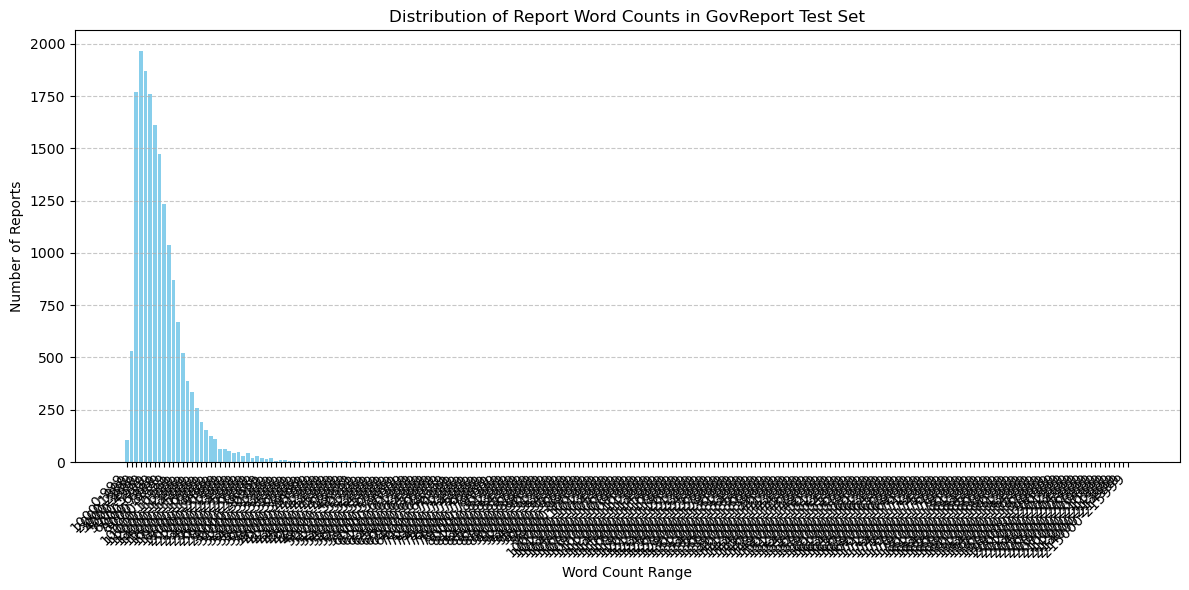

In [5]:
import json
import matplotlib.pyplot as plt
from collections import Counter
import math

# Load the test.json file
with open("govreport_json/train.json", "r", encoding="utf-8") as f:
    data = [json.loads(line) for line in f]

# Calculate word counts for each report
word_counts = [len(item["document"].split()) for item in data]

# Define buckets (each bucket = 1000 words)
bucket_size = 1000
max_words = max(word_counts)
num_buckets = math.ceil(max_words / bucket_size)

# Count the number of reports in each bucket
buckets = [f"{i*bucket_size}-{(i+1)*bucket_size-1}" for i in range(num_buckets)]
bucket_counts = Counter()

for count in word_counts:
    bucket_index = count // bucket_size
    bucket_range = f"{bucket_index*bucket_size}-{(bucket_index+1)*bucket_size-1}"
    bucket_counts[bucket_range] += 1

# Ensure all buckets are present (even if count is 0)
bucket_values = [bucket_counts.get(b, 0) for b in buckets]

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.bar(buckets, bucket_values, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Word Count Range")
plt.ylabel("Number of Reports")
plt.title("Distribution of Report Word Counts in GovReport Test Set")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
